In [1]:
import numpy as np
from scipy.linalg import svdvals
from matplotlib import pyplot as plt
import time

In [2]:
m = 40
n = 100

We first set up the problem
\begin{align*}
    Ax = b
\end{align*}
where we $A$ is a random, standard Gaussian matrix of dimension $m \times n$ (where the actual size of $m,n$ are defined in the cell immediately above), the true $x$ has 10 randomly selected spikes, and $b$ is given by
\begin{align*}
    b = Ax + \gamma y
\end{align*}
where $y$ is a standard Gaussian noise vector.

In [124]:
gamma = 0.05
A = np.random.normal(0,1,(m,n))
x_true = np.zeros(n)
idx_spike = np.random.randint(0,n,10)
x_true[idx_spike] = 1
b = np.dot(A,x_true) + gamma*np.random.normal(0,1,m)

Here we initialize a first "guess" for $x$.

In [125]:
x_init = np.ones(n)

Now we want to find a potential answer to our inverse problem and solve for some $x$. To do this, we first calculate the $\lambda$ hyperparameter used in the regularized linear least squares problem:
\begin{align*}
     \displaystyle \min_{x} \frac{1}{2}||Ax - b||^{2} + \lambda R(Cx).
\end{align*}
Since we are first implementing the lasso method, we know necessarily that $R(Cx) = ||x||_1$.

In [126]:
lam = np.linalg.norm(np.dot(A.T, b),ord=np.inf)/10

## Section 1 - Implementing simple Lasso

First, we are going to implement the Lasso method. Since Lasso necessarily uses the $||\cdot ||_1$ norm, then we define 
\begin{align}
    \mathrm{prox}_{\lambda || \cdot ||_1}(x) = \mathrm{sign}(x)\mathrm{max}(|x|-\lambda,0)
\end{align}
Note, it is necessary that $x \in \mathbb{R}$.

Here we create a maximum function that compares every element in a $\verb+numpy+$ array to a desired number (of type float or int) and returns a vector of like dimension that has taken the maximum value between the desired number and every element in the array.

In [99]:
def max_function(x, num_compare):
    return np.array([i if i >= num_compare else num_compare for i in x], dtype=float)

This function implements formula (1). Note that every operation is completed entry-wise.

In [100]:
def prox_op(x,lambd):
    return np.sign(x)*max_function(np.abs(x)-lambd,0)

In [119]:
cond_A = svdvals(A)[0]
eta = 0.001
k = 0
tol = 0.00001
max_step = 100
assert eta <= 1/(cond_A**2)

We now create a $\verb+lasso+$ function that will perform the desired prox-gradient descent and solve the inverse problem constructed, with the intent of creating an $\verb+x_guess+$ vector that is as close to $\verb+x_true+$ as possible.

In [9]:
def lasso(x, max_step, k, eta, lam, tol):
    start = time.time()
    while (max_step > tol):
        k += 1
        x_old = x
        x = prox_op(x_old - eta*(A.T)@((A@x_old)-b),eta*lam)
        step = abs((x - x_old)/eta)
        max_step = step.max()
    end = time.time()
    return x, start, end, k

Now we are going to run our $\verb+lasso+$ function and see if, at the very least, it includes the nonzero entries inside our $\verb+x_true+$ vector.

In [10]:
x_guess, start, end, iters = lasso(x_init, max_step, k, eta, lam, tol)

In [11]:
x_guess_nonzero = np.nonzero(x_guess)
x_true_nonzero = np.nonzero(x_true)

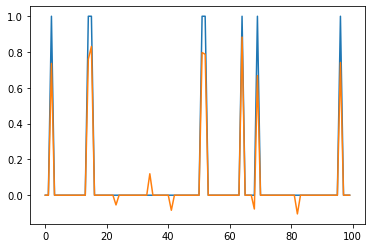

In [12]:
from matplotlib import pyplot as plt
plt.plot(x_true)
plt.plot(x_guess)

In [13]:
np.isin(x_true_nonzero, x_guess_nonzero)

array([[ True,  True,  True,  True,  True,  True,  True,  True]])

From what is directly above, we see clearly that all the nonzero entries inside our true solution $\verb+x_true+$ are at least inside the solution given by the lasso regression, $\verb+x_guess+$. Though, note that the number of nonzero entries in $\verb+x_guess+$ is greater than that of $\verb+x_true+$:

In [14]:
print("This is the number of nonzero entries in x_guess: " + str(len(x_guess_nonzero[0])))
print("This is the number of nonzero entries in x_true: " + str(len(x_true_nonzero[0])))

This is the number of nonzero entries in x_guess: 13
This is the number of nonzero entries in x_true: 8


Hence, there is imprecision in that we would prefer to have more entries in $\verb+x_guess+$ to be closer to 0.

We also show the number of iterations and the time it takes for the lasso method to converge:

In [15]:
print("This is the number of iterations required for lasso to converge: " + str(iters))
print("This is the number of seconds it takes for lasso to converge: " + str(end - start))

This is the number of iterations required for lasso to converge: 1785
This is the number of seconds it takes for lasso to converge: 0.08985209465026855


## Section 2 - SR3 method

We will compare the above to the SR3 method. For reference, the general SR3 formulation is as follows:
\begin{align*}
    \displaystyle \min_{x,w} \frac{1}{2}||Ax-b||^{2} + \lambda R(w) + \frac{\kappa}{2}||Cx - w||^{2}.
\end{align*}
We first want to recover a relaxed version of lasso. To do this, we take $R(\cdot) = ||\cdot ||_{1}$ and $C=I$. In this instance as well, we take $\kappa = 100$. We proceed as follows. 

In [16]:
C = np.eye(n,n)
kappa = 0.1
lam_sr3 = (lam/(1 + cond_A**2))*kappa

Central to the algorithm we implement is
\begin{align*}
    H_{\kappa} = A^{\top}A + \kappa C^{\top}C .
\end{align*}
We define this matrix immediately below.

In [17]:
H_k = np.dot(A.T,A) + kappa*np.dot(C.T,C)
H = np.linalg.inv(H_k)
w = np.ones(n)

We now implement the algorithm for SR3

In [18]:
k_sr3 = 0
eta = 1/kappa
max_step = 100

In [19]:
def sr3(w, H, A, b, C, max_step, k, eta, tol, kappa, lam):
    start = time.time()
    while (max_step > tol):
        k += 1
        w_old = w
        x = H@(np.dot(A.T, b) + kappa*np.dot(C.T, w_old))
        w = prox_op(np.dot(C,x),eta*lam)
        step = abs((w - w_old)/eta)
        max_step = step.max()
    end = time.time()
    return w, start, end, k

In [20]:
w_guess, start_sr3, end_sr3, iters_sr3 = sr3(w,H,A,b,C,max_step,k_sr3,eta,tol,kappa,lam_sr3)

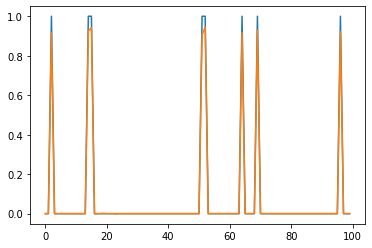

In [21]:
plt.plot(x_true)
plt.plot(w_guess)

In [22]:
w_guess_nonzero = np.nonzero(w_guess)
np.isin(x_true_nonzero, w_guess_nonzero)

array([[ True,  True,  True,  True,  True,  True,  True,  True]])

Clearly, $\verb+w_guess+$ contains nonzero entries in mostly the same places as does $\verb+x_true+$. Next, we look at how many nonzero entries there are in $\verb+w_guess+$.

In [23]:
print("This is the number of nonzero entries in w_guess: " + str(len(w_guess_nonzero[0])))
print("This is the number of nonzero entries in x_true: " + str(len(x_true_nonzero[0])))

This is the number of nonzero entries in w_guess: 11
This is the number of nonzero entries in x_true: 8


Note that, even though there are more nonzero entries in $\verb+w_guess+$ than in $\verb+x_true+$, the number of non-sparse entries is much closer than what was obtained using the standard lasso method, using all the same parameters. Thus, we have a higher level of precision, as we desired.

Last, we look at the number of iterations SR3 took to converge and the number of seconds required fro convergence.

In [24]:
print("This is the number of iterations required for SR3 to converge: " + str(iters_sr3))
print("This is the number of seconds it takes for SR3 to converge: " + str(end_sr3 - start_sr3))

This is the number of iterations required for SR3 to converge: 88
This is the number of seconds it takes for SR3 to converge: 0.00992584228515625


Note that, even for a small-dimension problem, the number of iterations required for SR3 to converge is decreased by an order of 10, as for the number of seconds required for convergence. This is exactly what we anticipated from the results shown in J33.

Use relationship between condition number of $A^{\top}A$ to get $\lambda$ parameter value for relaxed problem. It's how I define it using the variable $\verb+lam_sr3+$.

Next, we seek to deblur an image using SR3, implementing the FISTA algorithm.

## Section 3 - FISTA on non-image data

Before we do image deblurring, we're just going to run FISTA on the contrived data. So we reinitialize everything according to Section (1) again

In [127]:
cond_A = svdvals(A)[0]
eta = 0.001
k = 0
tol = 0.00001
max_step = 100
t = 1
L = np.linalg.eigvals(A.T@A)[0]
Linv = 1/L
assert eta <= 1/(cond_A**2)

In [123]:
def FISTA_norm(x, y, t, max_step, k, lam, tol):
    start = time.time()
    while (max_step > tol):
        k += 1
        x_old = x
        y_old = y
        t_old = t
        z = y_old - Linv*(A.T)@((A@y_old)-b)
        x = prox_op(z, lam*Linv)
        t = (1 + np.sqrt(1 + 4*t_old**2))/2
        y = x + ((t_old-1)/t)*(x - x_old)
        step = abs((y - y_old)*Linv)
        max_step = step.max()
    end = time.time()
    return y, start, end, k

In [128]:
y_fista, start, end, k_fista = FISTA_norm(x_init, x_init, t, max_step, k, lam, tol)

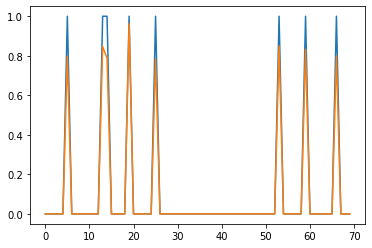

In [129]:
from matplotlib import pyplot as plt
plt.plot(x_true)
plt.plot(y_fista)

The results from the plot are encouraging since they tell us that our vanilla FISTA model running on just the contrived data seems to be working.

In [130]:
y_fista_nonzero = np.nonzero(y_fista)
x_true_nonzero = np.nonzero(x_true)
np.isin(x_true_nonzero, y_fista_nonzero)

array([[ True,  True,  True,  True,  True,  True,  True,  True]])

In [131]:
print("This is the number of nonzero entries in y_fista: " + str(len(y_fista_nonzero[0])))
print("This is the number of nonzero entries in x_true: " + str(len(x_true_nonzero[0])))

This is the number of nonzero entries in y_fista: 8
This is the number of nonzero entries in x_true: 8


In [132]:
print("This is the number of iterations required for FISTA to converge: " + str(k_fista))
print("This is the number of seconds it takes for FISTA to converge: " + str(end - start))

This is the number of iterations required for FISTA to converge: 31
This is the number of seconds it takes for FISTA to converge: 0.002595186233520508


I'm not really going to comment on any of this. Needless to say, FISTA is working about as well as we could hope.

## Section 4 - FISTA on image deblurring

In [6]:
import pywt
import pywt.data

Here we are importing the cameraman image and simply scaling the values of that image to be in between 0 and 1, as done in the FISTA paper.

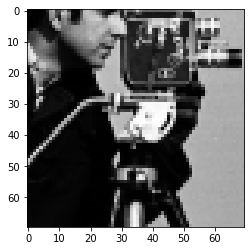

In [7]:
original = plt.imread("cameraman256.png")
original = original[60:130,100:170]
plt.imshow(original,interpolation="nearest",cmap=plt.cm.gray)

In [8]:
m=original.shape[0]
n=original.shape[1]

We are now going to blur this image, following the details provided in the FISTA paper. To do this, we pass the image through a Gaussian blur of size $9 \times 9$ and standard deviation 4, which we follow by adding on a zero-mean white Gaussian noise with standard deviation $10^{-3}$.

To pass the image through the Gaussian blur, we first need to import a package from $\verb+scipy+$ and create a function on our own to approximate the $\verb+imfilter+$ and $\verb+fspecial+$ functions in $\verb+MATLAB+$.

In [9]:
from scipy.ndimage import correlate, convolve
from scipy.signal import convolve2d
from scipy.fftpack import dct 

In [10]:
def fspecial(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [11]:
h = fspecial((9,9),1)
blurred = correlate(original, h, mode="nearest")

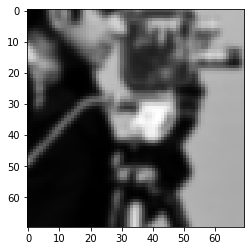

In [12]:
plt.imshow(blurred,interpolation="nearest", cmap=plt.cm.gray)

As we can see, this successfully blurred the image as we desired. Now we look to construct the problem by first constructing our blur operator.

In [13]:
R = np.zeros((m**2,m**2))
for i in range(m):
    for j in range(n):
        original_pixel = np.zeros_like(original)
        original_pixel[i,j] = 1
        blurred_pixel = convolve(original_pixel,h,mode="constant",cval=0.0)
        R[i*n+j,:] = blurred_pixel.flatten()

Now we construct our Wavelet matrix $W$. Actually, I might not need the $W$ matrix. All we need for it to be really is the wavelet operator, which I think would just be $\verb+wav_x+$ and then $W$ is the resulting image in the wavelet space. Do I do the wavelet transform for each iteration? I think so! Essentially $W = \verb+pywt.wavedec2()+$. I just have to be careful to throw in the actual matrix everytime, not the vectorized form.

In [60]:
def wavelet_operator(orig):
    coeffs = pywt.wavedec2(orig, wavelet="haar", level=3)
    wav_x, _ = pywt.coeffs_to_array(coeffs)
    wav_x = wav_x[0:m,0:m]
    W = np.reshape(wav_x, (m**2,1))
    return W

Finally, we can construct our matrix $A$ and compute the largest eigenvalue to extract the Lipschitz constant.

In [195]:
def wavelet_operator_1d(org,m):
    coeffs = pywt.wavedec(org, wavelet="haar", level=3)
    wav_x, _ = pywt.coeffs_to_array(coeffs)
    W = wav_x[:m**2]
    return (W,coeffs)

In [15]:
A = R.copy()

In [16]:
ATA = A.T@A

Here we take the discrete 2D cosine transform of the matrix $A^\top A$. Once we do this, we can use the formula
\begin{align*}
    \lambda_{i} = \frac{[Ca_1]_{i}}{c_{i1}}
\end{align*}
where $a_1$ is the first column of $A^\top A$ and $C$ is the resulting matrix from the discrete cosine transform. I get this information from the book Deblurring Images.

In [88]:
C = dct(ATA)

In [196]:
evals_ATA = np.divide(np.dot(C,ATA[:,0]),C[:,0])
evals_ATA_sort = np.sort(evals_ATA, kind="heapsort")
L = evals_ATA_sort[-1]*2
Linv = 1/L
k_FISTA = 0
max_iter = 50

Now we are going to define our first guesses and reshape all of our data.

In [197]:
b = blurred.flatten("F")
x_init = np.ones(m**2)
y0 = x_init.copy()
t = 1
lam = 2e-1

Since we also need the gradient of
\begin{align*}
    f(x) = ||Ax-b||^{2}
\end{align*}
which is
\begin{align*}
    \nabla f(x) = 2A^{\top}(Ax-b)
\end{align*}
we define a quick anonymous function to do the calculations for us

In [186]:
# ATb = (A.T@b).reshape((m**2),1)
ATb = (A.T@b)

In [177]:
# x = x_init.reshape((m*m,1))
# y = y0.reshape((m*m,1))

In [178]:
bleh = ATA@x_init - ATb
bleh.shape

(4900,)

In [180]:
z = y0 - Linv*bleh
c = wavelet_operator_1d(z,m)
x = prox_op(wavelet_operator_1d(z,m),lam*Linv)


(4900,)

In [122]:
ATb.reshape((m*m,1))

array([[0.01795142],
       [0.02400348],
       [0.02541792],
       ...,
       [0.44710339],
       [0.42294622],
       [0.31431641]])

In [187]:
grad = lambda x: 2*(ATA@x - ATb)

In [198]:
x = x_init
y = y0
while (k_FISTA <= max_iter):
    k_FISTA += 1
    x_old = x
    y_old = y
    t_old = t
    z = y_old - Linv*grad(y_old)
    c = wavelet_operator_1d(z,m)
    x = prox_op(c[0],lam*Linv)
    t = (1 + (1+4*t_old**2)**(1/2))/2
    y = x + (t_old/t)*(x - x_old)

In [199]:
coeffs = pywt.array_to_coeffs(y,coeff_slices=c[1])
y_invwt = pywt.waverec(coeffs, wavelet="haar")
y_invwt

IndexError: arrays used as indices must be of integer (or boolean) type

In [208]:
y_fis = y.reshape(m,m)

In [209]:
y_fis.shape

(70, 70)

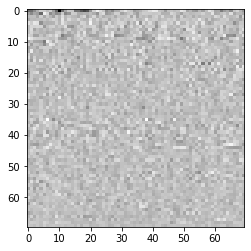

In [210]:
plt.imshow(y_fis,interpolation="nearest",cmap=plt.cm.gray)

In [27]:
def FISTA(x, y, t, k, lam, max_iter):
    start = time.time()
    while (k <= max_iter):
        k += 1
        print("On iteration " + str(k))
        x_old = x
        y_old = y
        t_old = t
        print("Calculating gradient...")
        z = y_old - Linv*grad(y_old)
        print("Entering proximal gradient and wavelet...")
        x = prox_op(wavelet_operator(np.reshape(z, (m,m))),lam*Linv)
        t = (1 + (1+4*t_old**2)**(1/2))/2
        y = x + (t_old/t)*(x - x_old)
    end = time.time()
    return y, start, end, k

In [28]:
x_FISTA, start, end, k_FIS = FISTA(x_init, y0, t, k_FISTA, lam, max_iter)

In [101]:
y_mat = np.reshape(y0, (m,m))

In [112]:
coeffs = pywt.wavedec2(y_mat, wavelet="haar", level=3)
wav_x, _ = pywt.coeffs_to_array(coeffs)
wav_x = wav_x[0:m,0:m]
W = np.reshape(wav_x, (m**2,1))

In [108]:
wav_x.shape

(71, 71)

In [109]:
y_mat.shape

(70, 70)